# TP1 - REDIS - Adrián José Zapater Reig.

Tenemos:
- user_id - Que es un contador incremental automático para obtener el siguiente id de usuairo libre.
- post_id
- users - Set para convertir de id a nombre y de nombre a id. Cada usuario se da de alta 2 veces
- 

In [1]:
# Clase estática que contiene las constantes de los nombres de las colecciones de REDIS y sus campos.
class Post(object):
    # Contador incremental de id de post:
    c_post_id = 'post_id'
    
    # Hash que representa un post. {user_id, body, ts}.
    base_s = 'post:{}'
    # Campos del Hash.
    id_creador = 'user_id'
    cuerpo = 'body'
    ts = 'timestamp'
    
    # Set con el TS de cada post para poder ordernar con un SORT
    post_ts_s = 'post_ts_{}'

In [2]:
# Clase estática que contiene las constantes de los nombres de las colecciones de REDIS y sus campos.
class User(object):
    # Contador incremental de id de usuario:
    c_user_id = 'user_id'
    
    # Hash de traducción nombre usuario <-> id usuario. {id, username}
    # Cada usuario aparece 2 veces: 1 por el id (users:1) y otra por el nombre (users:miguel)
    base_hs = 'users:{}'
    id_usuario = 'id'
    nombre = 'username'
    
    # Set de posts creados por un id usuario o por sus followings siempre que la fecha del post sea superior a la fecha de following.
    posts_s = 'posts:{}'
    
    # Set Ordenado de los followers de un id usuario por su timestamp.
    # Habrá que expresar el TS en algún formato que permita la comparativa alfanumérica.
    followers_zs = 'followers:{}'
    
    # Set Ordenado de los followings de un id usuario por su timestamp.
    # Habrá que expresar el TS en algún formato que permita la comparativa alfanumérica.
    followings_zs = 'followings:{}'

In [31]:
import redis

class TwitterBackend(object):    
    def __init__(self, host='127.0.0.1',port=6379, password=''):
        # Usamos  decode_responses=True para evitar tener que decodificar todas las respuestas de REDIS.
        self._db = redis.Redis(host=host,port=port, password=password, decode_responses=True)
        
    def restarDB(self):
        '''Borra todas las keys de la base de datos.'''
        self._db.flushall()
    
    def nuevo_usuario(self, username):
        '''Da de alta un nuevo usuario y devuelve el nuevo id. Devuelve None si el usuario ya existía.'''
        # Comprobamos si el usuario existe.
        is_new_user = self.get_id_usuario_by_nombre(username) is None
        if(is_new_user):
            # Nuevo id de usuario.
            usr_id = self._db.incr(User.c_user_id)
            # Insertamos el nuevo usuario por id
            x = self._db.hmset(User.base_hs.format(usr_id), {User.id_usuario:usr_id, User.nombre:username})
            # Insertamos el nuevo usuario por nombre
            x = self._db.hmset(User.base_hs.format(username), {User.id_usuario:usr_id, User.nombre:username})
            return usr_id
        
    def _nuevo_follower(self, orig_usrname, follower_usrname, ts):
        '''
        Inserta un nuevo follower.
        Devuelve True si logra insertarlo y False si falla o si ya existe.
        Si no existe el usuario original o el usuario follower, también devuelve False.
        '''
        res = False
        # Obtenemos los ids del usuario original y su follower.
        id_follower = self.get_id_usuario_by_nombre(follower_usrname)
        id_orig_usr = self.get_id_usuario_by_nombre(orig_usrname)
        
        # Comprobamos si existen ambos usuarios.
        if((not id_follower is None) and (not id_orig_usr is None)):
            # Damos de alta la relación.
            # Devuelve 1 si hace el insert y 0 si no. bool(1) = True y bool(0) = False.
            res = bool(self._db.zadd(User.followers_zs.format(id_orig_usr), {id_follower:ts}))
        
        return res
    
    def _nuevo_following(self, orig_usrname, following_usrname, ts):
        '''
        Inserta un nuevo following.
        Devuelve True si logra insertarlo y False si falla o si ya existe.
        Si no existe el usuario original o el usuario follower, también devuelve False.
        '''
        res = False
        # Obtenemos los ids del usuario original y su following.
        id_following = self.get_id_usuario_by_nombre(following_usrname)
        id_orig_usr = self.get_id_usuario_by_nombre(orig_usrname)
        
        # Comprobamos si existen ambos usuarios.
        if((not id_following is None) and (not id_orig_usr is None)):
            # Damos de alta la relación.
            res = bool(self._db.zadd(User.followings_zs.format(id_orig_usr), {id_following:ts}))
        
        return res
    
    def seguir(self, orig_usrname, following_usrname, ts):
        '''
        Formaliza que un usuario original sigue a un usuario following dando de alta los following y los followers.
        Devuelve True si logra insertarlo y False en caso contrario.
        Si hay un error al dar de alta el following, no continua con el follower.
        '''
        # Validamos si TS es numerico.
        self._validaTs(ts);
        
        res = self._nuevo_following(orig_usrname, following_usrname, float(ts))
        return res and self._nuevo_follower(following_usrname, orig_usrname, float(ts))
    
    def nuevo_post(self, usrname, body, ts):
        
        # Validamos si TS es numerico.
        self._validaTs(ts);
        
        res = False
        # Recuperamos el id de usuario que escribió el tweet.
        id_usr = self.get_id_usuario_by_nombre(usrname)
        
        # Comprobamos si existe.
        if (not id_usr is None):
            # Calculamos el siguiente id.
            id_post = self._db.incr(Post.c_post_id)
            # guardamos el post.
            res = self._db.hmset(Post.base_s.format(id_post), {Post.id_creador: id_usr, Post.cuerpo:body, Post.ts:ts})
            # Guardamos el TS del post para poder ordenar con SORT mas adelante...
            res = res and bool(self._db.set(Post.post_ts_s.format(id_post), ts))
            
        # Debemos actualizar los posts por usuario.
        # Primero el autor del post:
        res = res and bool(self._db.sadd(User.posts_s.format(id_usr), id_post))
        
        # Ahora hay que actualizar la lista de posts de los followers del autor, 
        # pero sólo si la fecha del post es posterior a la fecha del follow.
        # Obtenemos los followers del creador del post que le siguieron antes de la fecha de creación del post.
        followers = self._db.zrangebyscore(User.followers_zs.format(id_usr), 0, ts)
        for follower_id in followers:
            res = res and bool(self._db.sadd(User.posts_s.format(follower_id), id_post))
        
        return res
        
           
    #######################
    # Auxiliary functions:#
    #######################
    def get_id_usuario_by_nombre(self, username):
        '''Devuelve el id de usuario asignado al nombre proprocionado o None si no existe.'''
        return self._db.hget(User.base_hs.format(username), User.id_usuario)
    
    def get_nombre_usuario_by_id(self, usr_id):
        '''Devuelve el nombre de usuario asignado al id proprocionado o None si no existe.'''
        return self._db.hget(User.base_hs.format(usr_id), User.nombre)
    
    def _get_tm_user(self, id_usr):
        return self._db.smembers(User.posts_s.format(id_usr))
    
    def _validaTs(self, ts):
        # ts tiene que ser un entero, sino Redis levantará un error.
        # Vamos a comprobarlo y sino levantaremos una excepción que sea facil de identificar.
        try:
            float(ts)
        except Exception as err:
            raise Exception("Timestamp tiene que ser un valor numérico, sino REDIS levantará un error.", err)
        
back = TwitterBackend()

# Conjunto de Datos

In [4]:
import pandas as pd
import os

# Carpeta donde se encuentran los ficheros de datos.
data_dir = os.path.join('..', 'data')

post_file = os.path.join(data_dir, 'twitter_sample.csv')
relations_file = os.path.join(data_dir, 'relations.csv')

posts = pd.read_csv(post_file, header=0, sep=',', quotechar='"', encoding='utf-8')
relations = pd.read_csv(relations_file, header=0, sep=',', quotechar='"', encoding='utf-8')

## Limpieza de twitter_sample

Ha aparecido una columna no esperada: "Unnamed: 3":

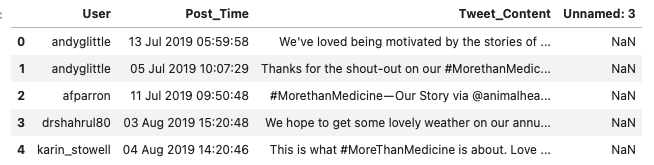

Todo apunta aque hay algún tweet que no tiene "comillas" y contiene una com en el contenido del tweet.

In [5]:
posts[posts['Unnamed: 3'].notna()]

,User,Post_Time,Tweet_Content,Unnamed: 3
19,roxanefeller,22 Aug 2019 11:37:13,Plan a fun family day out &amp,join us on our annual sponsored 6 mile walk o...
24,cathcooney,01 Aug 2019 01:24:50,Really informative read - focusing on funding ...,environmental factors) has the possibility to...


Como podemos ver en el resultado de la casilla de arriba, son 2 los tweets afectados.
Para solucionarlo vamos a:
- sustituir los na por cadena de texto vacía: ''
- Unir la columns Tweet_content y Unamed: 3
- Borrar la columna Unnamed: 3

In [6]:
posts['Unnamed: 3'].fillna("", inplace=True)
posts['Tweet_Content'] = posts['Tweet_Content'] + posts['Unnamed: 3']

posts.drop(columns='Unnamed: 3', inplace=True)
posts.head()

,User,Post_Time,Tweet_Content
0,andyglittle,13 Jul 2019 05:59:58,We've loved being motivated by the stories of ...
1,andyglittle,05 Jul 2019 10:07:29,Thanks for the shout-out on our #MorethanMedic...
2,afparron,11 Jul 2019 09:50:48,#MorethanMedicine — Our Story via ⁦@animalhea...
3,drshahrul80,03 Aug 2019 15:20:48,We hope to get some lovely weather on our annu...
4,karin_stowell,04 Aug 2019 14:20:46,This is what #MoreThanMedicine is about. Love ...


Ahora vamos a comprobar si hay algún NA en las columnas:

In [7]:
posts[posts['User'].isna() | posts['Post_Time'].isna() | posts['Tweet_Content'].isna()]

,User,Post_Time,Tweet_Content
14,NaN,02 Jul 2019 20:56:39,@stemagno74 @wcrfint @macmillancancer @NIHRres...


Existe un tweet que no tiene usuario, como no podemos inferir quién es el creador del tweet, lo tendremos que descartar:

In [8]:
# Descartamos por id.
clean_posts = posts.drop(14)
clean_posts.head()

,User,Post_Time,Tweet_Content
0,andyglittle,13 Jul 2019 05:59:58,We've loved being motivated by the stories of ...
1,andyglittle,05 Jul 2019 10:07:29,Thanks for the shout-out on our #MorethanMedic...
2,afparron,11 Jul 2019 09:50:48,#MorethanMedicine — Our Story via ⁦@animalhea...
3,drshahrul80,03 Aug 2019 15:20:48,We hope to get some lovely weather on our annu...
4,karin_stowell,04 Aug 2019 14:20:46,This is what #MoreThanMedicine is about. Love ...


## Limpieza de relations

In [9]:
relations.head()

,User,Follows,Following_Time
0,roxanefeller,cathcooney,13 Jun 2019 05:59:58
1,andyglittle,charleskod,14 Jul 2019 10:07:29
2,andyglittle,seers_helen,18 Jul 2019 09:50:48
3,andyglittle,karin_stowell,31 Aug 2019 15:20:48
4,hanyshita,andyglittle,12 Jul 2019 14:20:46


El fichero parece tener el formato esperado. Vamos a comrpobar por si hay NAs.

In [10]:
relations[relations['User'].isna() | relations['Follows'].isna() | relations['Following_Time'].isna()]

,User,Follows,Following_Time


Confimado, el fichero está completo, con la estructura adecuada y sin NAs.

In [11]:
clean_relations = relations

## Tratamiento de Fechas:
Para poder indexar y ordenar por fechas es necesario convertir las fechas a un formato adecuado.

In [12]:
from datetime import datetime

# Clase estática que guarda funciones par el tratamiento de fechas.
class DateUtils(object):

    def date2ts(date_string, date_format = '%d %b %Y %H:%M:%S'):
        '''Convierte de fecha a timestamp'''
        return int(datetime.strptime(date_string, date_format).timestamp())

    def ts2date(ts, date_format = '%d %b %Y %H:%M:%S'):
        '''Convierte de Timestamp a fecha'''
        return datetime.fromtimestamp(ts).strftime(date_format)

# Probamos la función
print(DateUtils.date2ts('12 Jul 2019 14:20:46'))
print(DateUtils.ts2date(1562934046))

1562934046
12 Jul 2019 14:20:46


### Convertimos las fechas de los DataFrames a Timestamps

In [13]:
clean_posts['Post_Time'] = clean_posts['Post_Time'].apply(lambda date: DateUtils.date2ts(date))
clean_posts.head()

,User,Post_Time,Tweet_Content
0,andyglittle,1562990398,We've loved being motivated by the stories of ...
1,andyglittle,1562314049,Thanks for the shout-out on our #MorethanMedic...
2,afparron,1562831448,#MorethanMedicine — Our Story via ⁦@animalhea...
3,drshahrul80,1564838448,We hope to get some lovely weather on our annu...
4,karin_stowell,1564921246,This is what #MoreThanMedicine is about. Love ...


In [14]:
clean_relations['Following_Time'] = clean_relations['Following_Time'].apply(lambda date: DateUtils.date2ts(date))
clean_relations.head()

,User,Follows,Following_Time
0,roxanefeller,cathcooney,1560398398
1,andyglittle,charleskod,1563091649
2,andyglittle,seers_helen,1563436248
3,andyglittle,karin_stowell,1567257648
4,hanyshita,andyglittle,1562934046


## Carga de Datos
Para cargar los datos deberemos seguir los siguientes pasos:
- Obtener todos los usuarios que aparecen en los posts y en las relaciones y crearlos en nuestra DB.
- En segundo lugar debemos cargar las relaciones.
- Por último, cargaremos los posts.

In [15]:
posts_users = clean_posts.User.unique()
posts_users

array(['andyglittle', 'afparron', 'drshahrul80', 'karin_stowell',
       'cathcooney', 'dkalnow', 'alkhalilkouma', 'seers_helen',
       'hanyshita', 'roxanefeller', 'animalhealthEU', 'charleskod'],
      dtype=object)

In [16]:
relations_user_1 = clean_relations.User.unique()
relations_user_1

array(['roxanefeller', 'andyglittle', 'hanyshita', 'afparron', 'dkalnow',
       'animalhealthEU', 'seers_helen', 'alkhalilkouma', 'drshahrul80',
       'cathcooney', 'karin_stowell', 'charleskod'], dtype=object)

In [17]:
relations_user_2 = clean_relations.Follows.unique()
relations_user_2

array(['cathcooney', 'charleskod', 'seers_helen', 'karin_stowell',
       'andyglittle', 'animalhealthEU', 'drshahrul80', 'dkalnow',
       'roxanefeller', 'afparron', 'alkhalilkouma', 'hanyshita'],
      dtype=object)

Ahora hay que unirlos todos. Vamos a usar un SET para que no haya repetidos.

In [18]:
users = set(posts_users)
users.update(relations_user_1)
users.update(relations_user_2)

users

{'afparron',
 'alkhalilkouma',
 'andyglittle',
 'animalhealthEU',
 'cathcooney',
 'charleskod',
 'dkalnow',
 'drshahrul80',
 'hanyshita',
 'karin_stowell',
 'roxanefeller',
 'seers_helen'}

 #### Cargamos los usuarios en la BD:

In [19]:
back = TwitterBackend()
# Vaciamos la BD entre ejecuciones:
back.restarDB()

In [20]:
for user in users:
    res = back.nuevo_usuario(user)
    print('Creando Usuario {} con ID {}'.format(user, res))

Creando Usuario charleskod con ID 1
Creando Usuario cathcooney con ID 2
Creando Usuario hanyshita con ID 3
Creando Usuario drshahrul80 con ID 4
Creando Usuario seers_helen con ID 5
Creando Usuario afparron con ID 6
Creando Usuario dkalnow con ID 7
Creando Usuario roxanefeller con ID 8
Creando Usuario alkhalilkouma con ID 9
Creando Usuario andyglittle con ID 10
Creando Usuario animalhealthEU con ID 11
Creando Usuario karin_stowell con ID 12


<ipython-input-3-10423a675c96>:20: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  x = self._db.hmset(User.base_hs.format(usr_id), {User.id_usuario:usr_id, User.nombre:username})
<ipython-input-3-10423a675c96>:22: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  x = self._db.hmset(User.base_hs.format(username), {User.id_usuario:usr_id, User.nombre:username})


 #### Cargamos las relaciones en la BD:

In [21]:
clean_relations.head()

,User,Follows,Following_Time
0,roxanefeller,cathcooney,1560398398
1,andyglittle,charleskod,1563091649
2,andyglittle,seers_helen,1563436248
3,andyglittle,karin_stowell,1567257648
4,hanyshita,andyglittle,1562934046


In [22]:
for idx, row in clean_relations.iterrows():
    res = back.seguir(row['User'], row['Follows'], row['Following_Time'])
    print('Resultado de añadir relation {} - {} - {} = {}'.format(row['User'], row['Follows'], row['Following_Time'], res))

Resultado de añadir relation roxanefeller - cathcooney - 1560398398 = True
Resultado de añadir relation andyglittle - charleskod - 1563091649 = True
Resultado de añadir relation andyglittle - seers_helen - 1563436248 = True
Resultado de añadir relation andyglittle - karin_stowell - 1567257648 = True
Resultado de añadir relation hanyshita - andyglittle - 1562934046 = True
Resultado de añadir relation afparron - animalhealthEU - 1559361880 = True
Resultado de añadir relation dkalnow - animalhealthEU - 1561963226 = True
Resultado de añadir relation animalhealthEU - drshahrul80 - 1563541195 = True
Resultado de añadir relation animalhealthEU - dkalnow - 1566907024 = True
Resultado de añadir relation seers_helen - roxanefeller - 1572723037 = True
Resultado de añadir relation alkhalilkouma - drshahrul80 - 1564654679 = True
Resultado de añadir relation alkhalilkouma - animalhealthEU - 1562001903 = True
Resultado de añadir relation drshahrul80 - afparron - 1562100908 = True
Resultado de añadir 

 #### Cargamos las relaciones en la BD:

In [23]:
clean_posts.head()

,User,Post_Time,Tweet_Content
0,andyglittle,1562990398,We've loved being motivated by the stories of ...
1,andyglittle,1562314049,Thanks for the shout-out on our #MorethanMedic...
2,afparron,1562831448,#MorethanMedicine — Our Story via ⁦@animalhea...
3,drshahrul80,1564838448,We hope to get some lovely weather on our annu...
4,karin_stowell,1564921246,This is what #MoreThanMedicine is about. Love ...


In [24]:
for idx, row in clean_posts.iterrows():
    res = back.nuevo_post(row['User'], row['Tweet_Content'], row['Post_Time'])
    print('Resultado de crear nuevo post de {} : {}'.format(row['User'],res))

Resultado de crear nuevo post de andyglittle : True
Resultado de crear nuevo post de andyglittle : True
Resultado de crear nuevo post de afparron : True
Resultado de crear nuevo post de drshahrul80 : True
Resultado de crear nuevo post de karin_stowell : True
Resultado de crear nuevo post de andyglittle : True
Resultado de crear nuevo post de afparron : True
Resultado de crear nuevo post de cathcooney : True
Resultado de crear nuevo post de karin_stowell : True
Resultado de crear nuevo post de dkalnow : True
Resultado de crear nuevo post de alkhalilkouma : True
Resultado de crear nuevo post de seers_helen : True
Resultado de crear nuevo post de alkhalilkouma : True
Resultado de crear nuevo post de hanyshita : True
Resultado de crear nuevo post de dkalnow : True


<ipython-input-3-10423a675c96>:88: DeprecationWarning: Redis.hmset() is deprecated. Use Redis.hset() instead.
  res = self._db.hmset(Post.base_s.format(id_post), {Post.id_creador: id_usr, Post.cuerpo:body, Post.ts:ts})


Resultado de crear nuevo post de cathcooney : True
Resultado de crear nuevo post de roxanefeller : True
Resultado de crear nuevo post de drshahrul80 : True
Resultado de crear nuevo post de roxanefeller : True
Resultado de crear nuevo post de animalhealthEU : True
Resultado de crear nuevo post de dkalnow : True
Resultado de crear nuevo post de alkhalilkouma : True
Resultado de crear nuevo post de dkalnow : True
Resultado de crear nuevo post de cathcooney : True
Resultado de crear nuevo post de drshahrul80 : True
Resultado de crear nuevo post de andyglittle : True
Resultado de crear nuevo post de alkhalilkouma : True
Resultado de crear nuevo post de charleskod : True
Resultado de crear nuevo post de cathcooney : True
Resultado de crear nuevo post de dkalnow : True
Resultado de crear nuevo post de charleskod : True
Resultado de crear nuevo post de charleskod : True
Resultado de crear nuevo post de afparron : True
Resultado de crear nuevo post de cathcooney : True
Resultado de crear nuevo 

# 3.3 Pruebas
Creamos una subclase de TwitterBackend para ampliar la funcionalidad con los métodos de pruebas.

In [67]:
class PruebasTwitter(TwitterBackend):
    
    def __init__(self, host='127.0.0.1',port=6379, password=''):
        # Usamos  decode_responses=True para evitar tener que decodificar todas las respuestas de REDIS.
        self._db = redis.Redis(host=host,port=port, password=password, decode_responses=True)
    
    def obtener_followers(self, username):
        '''
        devolverá una lista con todos los nombres de los usuarios que le siguen,
        y en qué momento comenzaron a seguirle (en formato fecha, no “timestamp”), ordenados en el tiempo.
        '''
        res = []
        
        id_usr = self.get_id_usuario_by_nombre(username)
        
        if (id_usr is not None):
            # Como un usuario no puede tener un follower que le ha seguido en el futuro usamos el ts de 'ahora' como limite.
            now = int(datetime.now().timestamp())
            followers = self._db.zrangebyscore(User.followers_zs.format(id_usr), 0, now, withscores=True)
            
            for idx, ts in followers:
                f_username = self.get_nombre_usuario_by_id(idx)
                f_date = DateUtils.ts2date(ts)
                res.append((f_username, f_date))
                
        return res
                
    
    def obtener_followings(self, username):
        '''
        devolverá una lista con todos los nombres de los usuarios a los que sigue,
        y en qué momento comenzó a seguirlos (en formato fecha, no “timestamp”), ordenados en el tiempo.
        '''
        res = []
        
        id_usr = self.get_id_usuario_by_nombre(username)
        
        if (id_usr is not None):
            # Como un usuario no puede tener un followings seguidos en el futuro usamos el ts de 'ahora' como limite.
            now = int(datetime.now().timestamp())
            followings = self._db.zrangebyscore(User.followings_zs.format(id_usr), 0, now, withscores=True)
            
            for idx, ts in followings:
                f_username = self.get_nombre_usuario_by_id(idx)
                f_date = DateUtils.ts2date(ts)
                res.append((f_username, f_date))
                
        return res
    
    
    def obtener_timeline(self, username, tweets_propios=True):
        '''
        Devolverá todos los tweets correspondientes a dicho usuario (propios o publicados por los usuarios a los que sigue),
        ordenados por fecha de publicación del tweet.
        La salida exacta será el nombre del usuario que escribió el tweet, el cuerpo del tweet y el momento de publicación (en formato fecha, no “timestamp”)
        '''
        res = []
        
        id_usr = self.get_id_usuario_by_nombre(username)
        
        if (id_usr is not None):
            # Ordernamos por TS en order ascendente. Si se tuviera que ordernar del revés, se puede utilizar el parámetro DESC.
            all_posts =  self._db.sort(User.posts_s.format(id_usr), by=Post.post_ts_s.format('*'))
            
            for post_id in all_posts:
                post = self._db.hgetall(Post.base_s.format(post_id))
                p_id_usr = post['user_id']
                
                # El post es del usuario. Comprobamos le flag tweets_propios.
                if((p_id_usr == id_usr and tweets_propios) or (p_id_usr != id_usr)):
                    p_usr = self.get_nombre_usuario_by_id(p_id_usr)
                    P_cuerpo = post['body']
                    P_fecha = DateUtils.ts2date(int(post['timestamp']))

                    res.append((p_usr, P_cuerpo, P_fecha))
        return res
            
pruebas = PruebasTwitter()       
                

In [26]:
pruebas.obtener_followers("animalhealthEU")

[('afparron', '01 Jun 2019 06:04:40'),
 ('charleskod', '01 Jul 2019 07:27:58'),
 ('dkalnow', '01 Jul 2019 08:40:26'),
 ('alkhalilkouma', '01 Jul 2019 19:25:03')]

In [27]:
pruebas.obtener_followings("animalhealthEU")

[('drshahrul80', '19 Jul 2019 14:59:55'), ('dkalnow', '27 Aug 2019 13:57:04')]

In [70]:
pruebas.obtener_timeline("animalhealthEU", True)

[('animalhealthEU',
  'To help avoid issues of social isolation requires innovative thinking #MentalHealthAwareness #morethanmedicine https://t.co/8HgR995Btc',
  '08 Jul 2019 12:54:41'),
 ('animalhealthEU',
  "Studies in biology 🧬&amp; then agriculture👨\u200d🌾led @ElancoEU's Ralph Heuser to both a profession &amp; a passion ❤️ for #animalhealth.\nAnd his family dog Russty plays an important reminder role as to why animal health is about so much #MorethanMedicine:\nhttps://t.co/lHt4RTbxwo https://t.co/FaHagVMx1m",
  '18 Jul 2019 09:15:56'),
 ('animalhealthEU',
  '@animalhealthEU @MSDAnimalHealth #morethanmedicine',
  '20 Jul 2019 19:32:06'),
 ('animalhealthEU',
  'By equipping vets with a wide range of tools, we help them keep pets and farm animals healthy, and happy! 👨\u200d⚕️👩\u200d⚕️\n#MorethanMedicine https://t.co/MdHKVmzdJ0',
  '21 Jul 2019 19:22:52'),
 ('animalhealthEU',
  'Another face behind our industry, another story, another profile but same passion ! \nRead about our Treasur

In [71]:
pruebas.obtener_timeline("animalhealthEU", False)

[('drshahrul80',
  "@somedocs @ShikhaJainMD @DrJaimeFriedman @usnehal @Dr_Stepheny @SadiaFMD @DrCJohns @RoxanneSukolMD @AlexMMTri @DrCorriel #FOAMed. #FOAMcc. #MedEd primarily focused in #EmergencyMedicine. Being a good #human that prioritizes others' #success and #learning not just as a physician but in life as a whole! #morethanmedicine",
  '27 Jul 2019 19:48:46'),
 ('drshahrul80',
  "🐕 66 million dogs\n🐈 74 million cats\n🐇 21 million rabbits\n\nWe know you love your pets, here's how we can help you care for them\n#MorethanMedicine https://t.co/7bR5W9mbIE",
  '29 Jul 2019 10:11:35'),
 ('drshahrul80',
  'Animal health solutions are so much #MorethanMedicine!\nOther examples of how we protect animal health ⬇️⬇️ https://t.co/9zqLhohGae',
  '31 Jul 2019 14:04:40'),
 ('drshahrul80',
  'We hope to get some lovely weather on our annual 6 mile sponsored walk on Sat 12 Oct, so why not join us and register here if you would like to raise funds to help others live well with cancer. https://t.co